# CIDEr etc.  and time for batch/learning rate combinations

### Logs with validation, 5 epochs, 2 runs

In [56]:
%matplotlib inline
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import subprocess
import os
import seaborn as sns

In [57]:
!ls logs/microseries/GTX_TITAN_X

val_5epoch


In [58]:
logdir = "logs/microseries/GTX_TITAN_X/val_5epoch"

In [59]:
filename_pattern=re.compile(r"imagecaption_.*\.log")
files=[]
comm = "ls -1 "+logdir
proc = subprocess.Popen(comm.split(" "),
                     stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
for line in iter(proc.stdout.readline,b''):
    m = filename_pattern.match(line)
    if m:
        files.append(os.path.abspath(os.path.join(logdir,line)))
len(files)

180

In [60]:
batch_learn_pattern = re.compile(r"_b(\d+)_l([0-9\.]+)_smp\d+_(\d+)") # Match against file name
output_pattern = re.compile(r"^(\d+),\s*([0-9\.]+),\s*([0-9\.]+)")
validation_pattern = re.compile(r"^{'Bleu_1':\s*([0-9e\-\.]+),\s*'Bleu_2':\s*([0-9e\-\.]+),\s*'Bleu_3':\s*([0-9e\-\.]+),\s*'Bleu_4':\s*([0-9e\-\.]+),\s*'ROUGE_L':\s*([0-9e\-\.]+),\s*'CIDEr':\s*([0-9e\-\.]+)}")

# Read minibatch size and 1st epoch time from files.
# Store in a DataFrame.
def fileToDF(logfile, debug=False):
    global output_pattern, batch_learn_pattern, validation_pattern
    
    logfile = logfile.strip(" \n")
    filename = os.path.basename(logfile)
    if debug: print "FILE",filename
    batch = 0
    learn = 0
    run = 0
    m = batch_learn_pattern.search(filename)
    if m:
        batch = int(m.group(1))
        learn = float(m.group(2))
        run = int(m.group(3))
        if debug: print "BS,LR,run:",batch,learn,run
    
    with open(logfile,"r") as f:
        lines = f.readlines()
        time = 0
        epoch = 0
        ind_e = 0 # DataFrame row number (index) for df_epochtime
        ind_v = 0 # DataFrame row number (index) for df_validation
        df_epochtime = pd.DataFrame(data=None,columns=["batch","lr","run",
                                                       "epoch","time","loss"])
        df_validation = pd.DataFrame(data=None,columns=["batch","lr","run",
                                                        "bleu1","bleu2","bleu3","bleu4",
                                                        "rouge","cider"])
        for line in lines:
            s = line.strip(' \n')            
            m2 = output_pattern.match(s)
            if m2:
                if debug: print line,
                epoch = int(m2.group(1))
                time = float(m2.group(2))
                loss = float(m2.group(3))        
                if debug: print "BS,LR,run,epoch,time,loss:",batch,learn,run,epoch,time,loss
                df_epochtime.loc[ind_e] = [batch,learn,run,epoch,time,loss]
                ind_e += 1
            else:
                m3 = validation_pattern.match(s)
                if m3:
                    if debug: print line,
                    bl1 = float(m3.group(1))
                    bl2 = float(m3.group(2))
                    bl3 = float(m3.group(3))
                    bl4 = float(m3.group(4))
                    rouge = float(m3.group(5))
                    cider = float(m3.group(6))
                    if debug: print "Bleu, Rouge, CIDEr:",bl1,bl2,bl3,bl4,rouge,cider
                    df_validation.loc[ind_v] = [batch,learn,run,
                                                bl1,bl2,bl3,bl4,
                                                rouge, cider]
                    ind_v += 1
    return (df_epochtime, df_validation)

In [61]:
def readLogs(logdir, debug=False, maxfiles=10000000):
    global filename_pattern
    files=[]
    comm = "ls -1 "+logdir
    proc = subprocess.Popen(comm.split(" "),
                         stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
    for line in iter(proc.stdout.readline,b''):
        m = filename_pattern.match(line)
        if m:
            files.append(os.path.abspath(os.path.join(logdir,line)))
            
    #if debug: print "files:",files
    df_epochtime = pd.DataFrame(data=None,columns=["batch","lr","run","epoch","time","loss"])
    df_validation = pd.DataFrame(data=None,columns=["batch","lr","run",
                                                        "bleu1","bleu2","bleu3","bleu4",
                                                        "rouge","cider"])
    filecounter=0
    for file in files:
        if debug: print file
        df_e1,df_v1 = fileToDF(file,debug)
        if len(df_e1) > 0:
            df_epochtime = pd.concat([df_epochtime,df_e1],ignore_index=True)
        if len(df_v1) > 0:
            df_validation = pd.concat([df_validation,df_v1],ignore_index=True)
        filecounter +=1
        if filecounter>=maxfiles:
            return df
    return (df_epochtime, df_validation)

In [62]:
print logdir
df_epochtime,df_validation = readLogs(logdir)

logs/microseries/GTX_TITAN_X/val_5epoch


In [63]:
df_epochtime.head()

,batch,lr,run,epoch,time,loss
0,12.0,0.0001,0.0,1.0,13.152927,6.950682
1,12.0,0.0001,0.0,2.0,12.557639,6.880223
2,12.0,0.0001,0.0,3.0,11.942655,7.026403
3,12.0,0.0001,0.0,4.0,12.185337,6.702591
4,12.0,0.0001,0.0,5.0,12.377736,6.864507


## Validation score

In [64]:
print df_validation.shape
df_validation.head()

(180, 9)


,batch,lr,run,bleu1,bleu2,bleu3,bleu4,rouge,cider
0,12.0,0.0001,0.0,0.039124,1.665212e-11,1.577966e-14,2.888857e-15,0.175870,0.000005
1,12.0,0.0001,1.0,0.039275,1.670210e-11,1.581464e-14,1.961865e-15,0.175881,0.000004
2,12.0,0.0001,2.0,0.039119,1.665342e-11,1.578093e-14,2.610852e-15,0.175809,0.000003
3,12.0,0.0005,0.0,0.097000,1.232945e-02,2.820214e-03,1.176706e-07,0.123437,0.004494
4,12.0,0.0005,1.0,0.045463,5.966847e-03,7.338424e-04,2.179277e-04,0.059580,0.000236


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x112a86710>]], dtype=object)

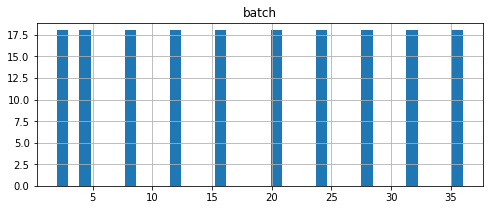

In [66]:
# Checking number of rows in the dataframe per batch size
# 6 LR values x 3 runs = 18 rows
plt.rcParams['figure.figsize'] = 8,3
df_validation[["batch"]].hist(bins=36)

In [67]:
# Two runs with same hyperparameters have quite! different scores
# Check scores for runs with BS 28
df_tmp = df_validation[(df_validation["batch"] == 28)]
df_tmp

,batch,lr,run,bleu1,bleu2,bleu3,bleu4,rouge,cider
72,28.0,0.0001,0.0,0.008197,0.000538,4.107123e-09,5.106972e-09,0.181313,0.000557
73,28.0,0.0001,1.0,0.007723,0.000513,2.698365e-09,3.678196e-09,0.179531,0.000557
74,28.0,0.0001,2.0,0.011725,0.000751,2.538940e-09,3.934358e-09,0.184654,0.000542
75,28.0,0.0005,0.0,0.103976,0.015513,1.131549e-03,5.476239e-08,0.119326,0.000125
76,28.0,0.0005,1.0,0.198925,0.016141,4.385026e-03,2.232924e-07,0.223890,0.001541
77,28.0,0.0005,2.0,0.062015,0.005577,1.605481e-03,6.969356e-08,0.078474,0.000072
78,28.0,0.0010,0.0,0.186346,0.021272,4.786224e-03,2.080678e-03,0.191378,0.005015
79,28.0,0.0010,1.0,0.184052,0.031977,1.017794e-02,4.192056e-03,0.168858,0.003732
80,28.0,0.0010,2.0,0.232888,0.040976,1.555477e-02,6.249459e-03,0.175895,0.015661
81,28.0,0.0020,0.0,0.200864,0.082965,4.850101e-02,2.690330e-02,0.174934,0.018885


In [68]:
df_tmp = pd.melt(df_tmp, id_vars=['batch', 'lr','run'])
df_tmp = df_tmp.drop(["batch"], axis=1)
df_tmp.head()

,lr,run,variable,value
0,0.0001,0.0,bleu1,0.008197
1,0.0001,1.0,bleu1,0.007723
2,0.0001,2.0,bleu1,0.011725
3,0.0005,0.0,bleu1,0.103976
4,0.0005,1.0,bleu1,0.198925


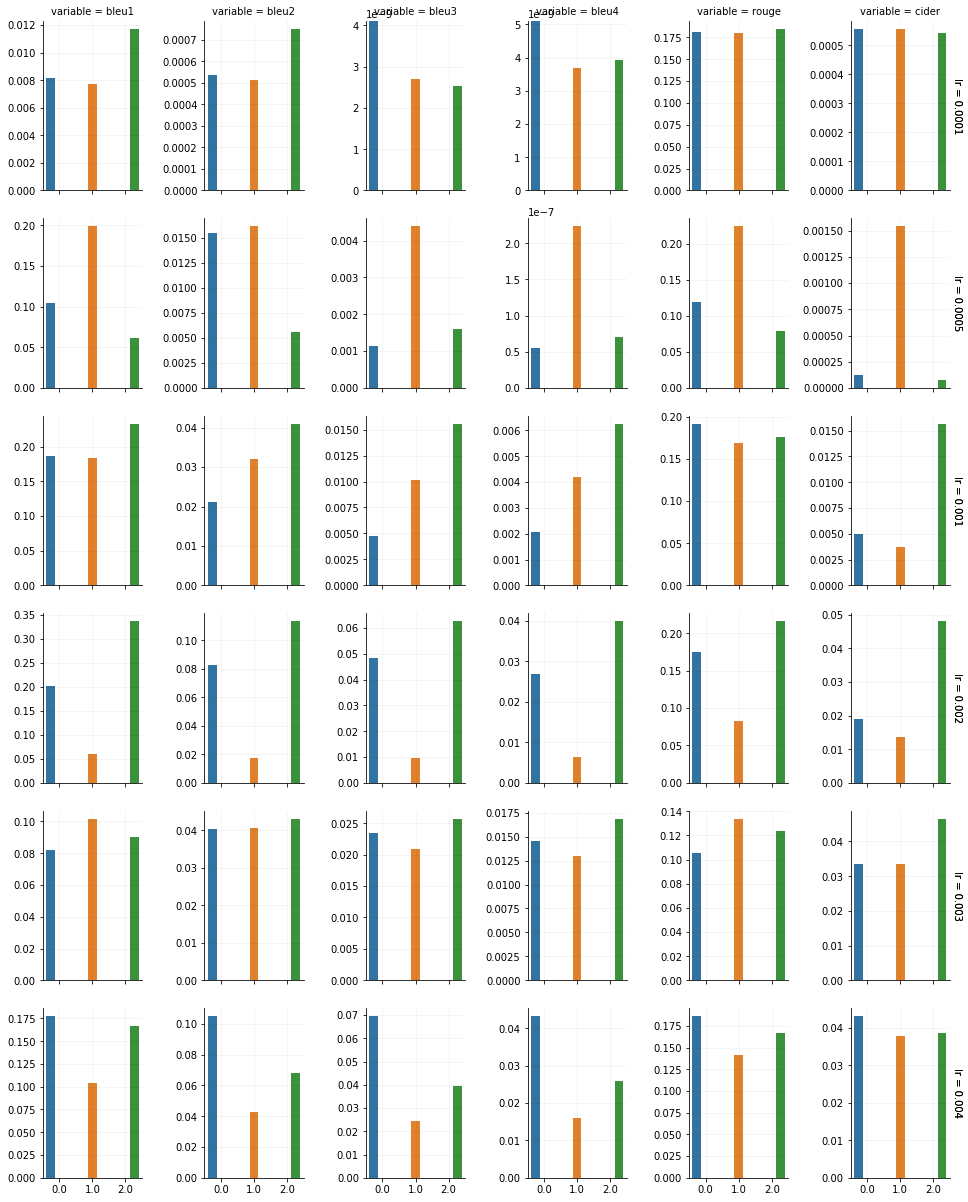

In [69]:
fg = sns.factorplot(x="run", y="value",row="lr",col="variable",hue="run",data=df_tmp, kind="bar",
                    legend=True,size=2.8,aspect=.8,sharey = False,margin_titles=True)
fg.map(plt.grid,alpha=.04,linewidth=0.5,aa=False,color="black")
plt.show()

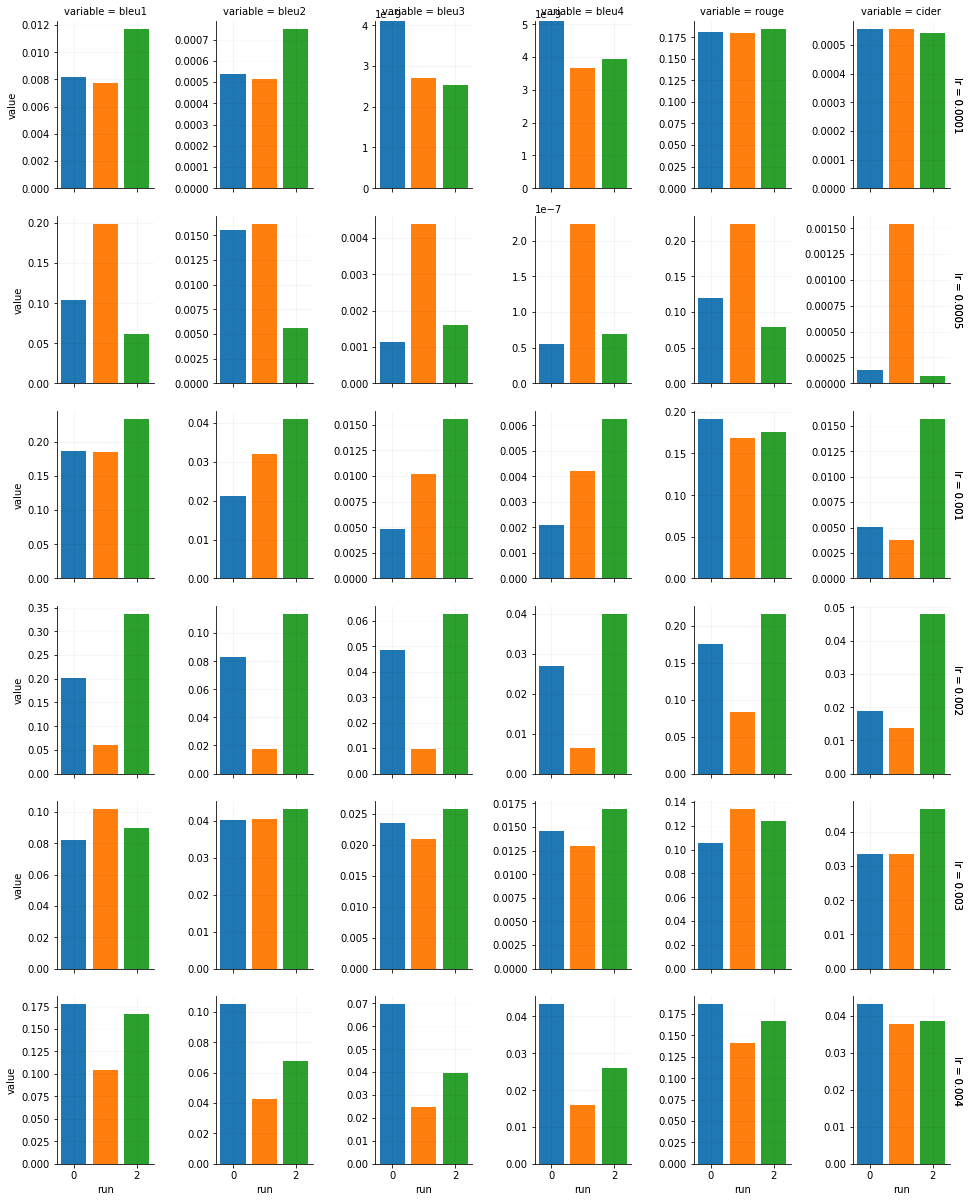

In [70]:
fg = sns.FacetGrid(df_tmp,col="variable",row="lr",hue="run",size=2.8,aspect=.8,sharey=False, margin_titles=True)
fg.map(plt.grid,alpha=.04,linewidth=0.5,aa=False,color="black")
fg.map(plt.bar,"run","value")
plt.show()

In [71]:
# Take average between runs
df_mean = df_validation.groupby(["batch","lr"]).mean().reset_index().drop(["run"],axis=1)
df_mean.head()

,batch,lr,bleu1,bleu2,bleu3,bleu4,rouge,cider
0,2.0,0.0001,0.133055,0.009626,0.002944,0.001173,0.173279,0.000612
1,2.0,0.0005,0.156392,0.076148,0.049299,0.029235,0.156147,0.004492
2,2.0,0.0010,0.105478,0.015476,0.003708,0.000578,0.104186,0.003468
3,2.0,0.0020,0.077608,0.022201,0.008916,0.003810,0.089663,0.006513
4,2.0,0.0030,0.145954,0.036380,0.011324,0.001625,0.187106,0.004837


In [72]:
df_cider = df_mean.pivot_table(index="batch",columns="lr",values="cider")
df_rouge = df_mean.pivot_table(index="batch",columns="lr",values="rouge")
df_blue1 = df_mean.pivot_table(index="batch",columns="lr",values="bleu1")
df_blue2 = df_mean.pivot_table(index="batch",columns="lr",values="bleu2")
df_blue3 = df_mean.pivot_table(index="batch",columns="lr",values="bleu3")
df_blue4 = df_mean.pivot_table(index="batch",columns="lr",values="bleu4")
df_cider.head()

lr,0.0001,0.0005,0.001,0.002,0.003,0.004
batch,,,,,,
2.0,0.000612,0.004492,0.003468,0.006513,0.004837,0.000543
4.0,0.002079,0.016503,0.037840,0.033350,0.026602,0.006803
8.0,0.000043,0.008929,0.050808,0.015625,0.062093,0.024030
12.0,0.000004,0.003006,0.042353,0.062836,0.069037,0.045360
16.0,0.000311,0.009311,0.025241,0.049273,0.040263,0.051682


In [73]:
def plotHeatMap(df,ax,title=None,cmap=None):        
    cmesh=ax.pcolormesh(df,cmap=cmap)
    fig.colorbar(mappable=cmesh,ax=ax)    
    ax.set_yticks(np.arange(0.5, len(df.index), 1))
    ax.set_yticklabels(df.index)
    ax.set_xticks(np.arange(0.5, len(df.columns), 1))
    ax.set_xticklabels(df.columns)
    ax.tick_params(direction='in', length=0)
    for y in range(df.shape[0]):
        for x in range(df.shape[1]):
            if df.iloc[y,x] > 0:
                ax.text(x+0.5,y+0.5,'{:.3f}'.format(df.iloc[y,x]),
                         color="black",fontsize=9,
                         horizontalalignment='center',
                         verticalalignment='center',                    
                         bbox={'facecolor':'white','edgecolor':'none', 'alpha':0.3, 'pad':0})
    ax.set_title(title,fontsize=18)

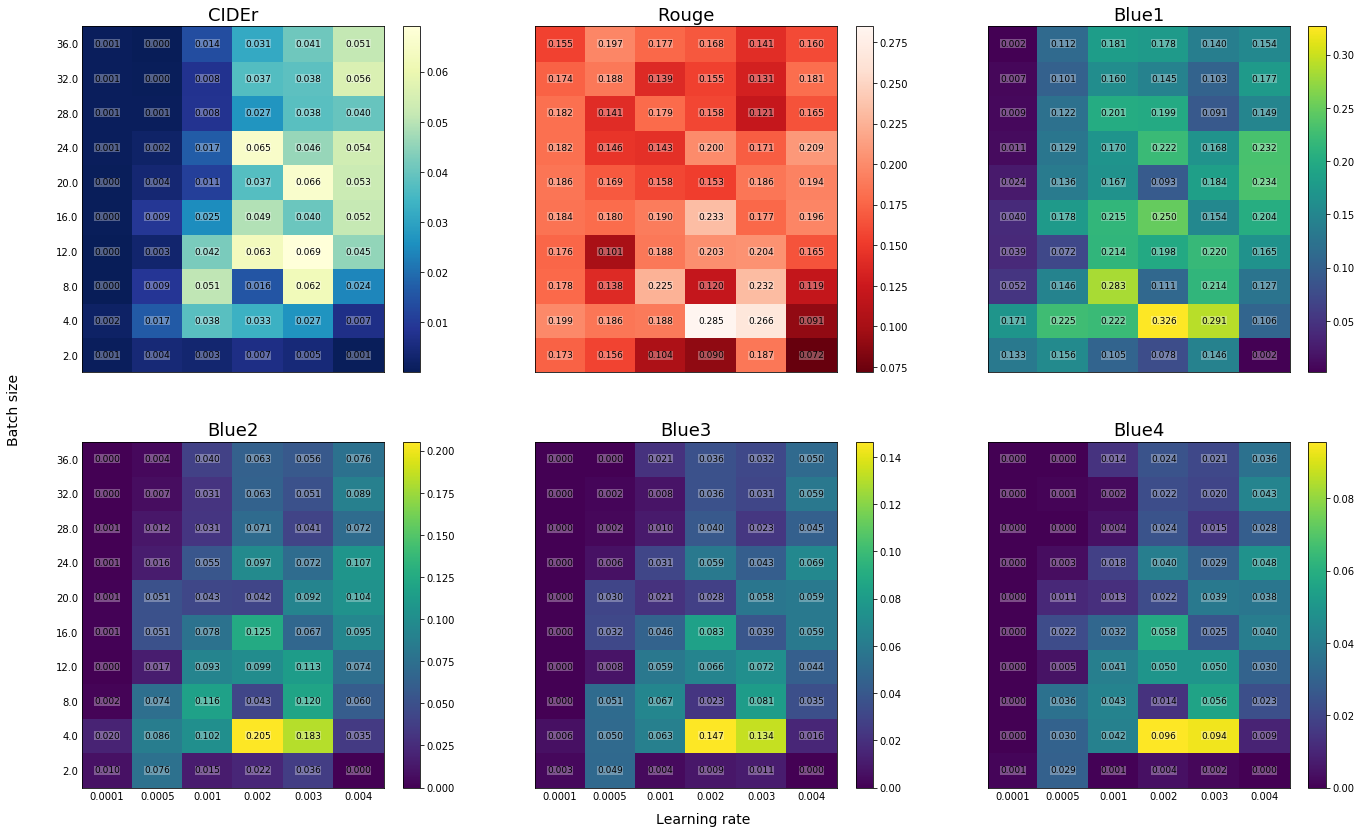

In [87]:
plt.rcParams['figure.figsize'] = 23,14
fig, ax = plt.subplots(2,3,sharex=True,sharey=True)
plotHeatMap(df_cider,ax[0,0],"CIDEr","YlGnBu_r")
plotHeatMap(df_rouge,ax[0,1],"Rouge","Reds_r")
plotHeatMap(df_blue1,ax[0,2],"Blue1")
plotHeatMap(df_blue2,ax[1,0],"Blue2")
plotHeatMap(df_blue3,ax[1,1],"Blue3")
plotHeatMap(df_blue4,ax[1,2],"Blue4")
fig.text(0.5, 0.09, 'Learning rate', ha='center',fontsize=14)
fig.text(0.08, 0.5, 'Batch size', va='center', rotation='vertical',fontsize=14)
fig.show()

## Loss and time

In [75]:
df_epochtime.head()

,batch,lr,run,epoch,time,loss
0,12.0,0.0001,0.0,1.0,13.152927,6.950682
1,12.0,0.0001,0.0,2.0,12.557639,6.880223
2,12.0,0.0001,0.0,3.0,11.942655,7.026403
3,12.0,0.0001,0.0,4.0,12.185337,6.702591
4,12.0,0.0001,0.0,5.0,12.377736,6.864507


In [76]:
# Take average between runs
df_mean_time = df_epochtime.groupby(["batch","lr"]).mean().reset_index()
df_mean_time.head()

,batch,lr,run,epoch,time,loss
0,2.0,0.0001,1.0,3.0,29.551603,6.793164
1,2.0,0.0005,1.0,3.0,29.707162,6.774854
2,2.0,0.0010,1.0,3.0,29.809397,6.787707
3,2.0,0.0020,1.0,3.0,29.866298,6.873951
4,2.0,0.0030,1.0,3.0,30.406243,7.029373


In [77]:
df_mean_time = df_mean_time.drop(["epoch","run","loss"],axis=1)
df_mean_time.head()

,batch,lr,time
0,2.0,0.0001,29.551603
1,2.0,0.0005,29.707162
2,2.0,0.0010,29.809397
3,2.0,0.0020,29.866298
4,2.0,0.0030,30.406243


In [78]:
time_T = df_mean_time.pivot_table(index="batch",columns="lr",values="time")
time_T.head()

lr,0.0001,0.0005,0.001,0.002,0.003,0.004
batch,,,,,,
2.0,29.551603,29.707162,29.809397,29.866298,30.406243,31.259651
4.0,19.127725,19.497030,21.334828,21.538022,19.678541,19.323931
8.0,14.141668,14.011173,14.192861,14.015494,14.193997,14.112501
12.0,12.382519,12.185191,12.369301,12.190668,12.151122,12.258677
16.0,11.912604,11.917710,11.982604,11.861392,11.907841,11.819495


### Loss

In [79]:
df_5 = df_epochtime[df_epochtime["epoch"]==5] # Use loss at epoch 5
df_5[(df_5["batch"]==2) & (df_5["lr"]==0.0001)]

,batch,lr,run,epoch,time,loss
454,2.0,0.0001,0.0,5.0,28.734963,6.267474
459,2.0,0.0001,1.0,5.0,29.514454,6.675419
464,2.0,0.0001,2.0,5.0,29.692151,6.336353


In [80]:
df_mean_loss = df_5.groupby(["batch","lr"]).mean().reset_index().drop(["epoch","time","run"],axis=1)
# Check correctness: df_mean_loss "loss" values must be mean no 3 values from df_5 (from different runs)
# This should be average of the df_5 loss values from the above table.
df_mean_loss[(df_mean_loss["batch"]==2) & (df_mean_loss["lr"]==0.0001)]

,batch,lr,loss
0,2.0,0.0001,6.426415


In [81]:
# Check correctness: df_mean_loss "loss" values must be mean no 3 values from df_5 (from different runs)
print df_5.loc[[454,459,464],["loss"]].mean().values
# This should be 0:
print df_5.loc[[454,459,464],["loss"]].mean().values[0] - df_mean_loss.loc[[0],["loss"]].values[0]

[ 6.42641533]
[ 0.]


In [82]:
loss_T = df_mean_loss.pivot_table(index="batch",columns="lr",values="loss")
loss_T.head()

lr,0.0001,0.0005,0.001,0.002,0.003,0.004
batch,,,,,,
2.0,6.426415,6.449434,6.531018,6.746689,6.391302,6.837575
4.0,6.873670,6.739287,6.709845,6.677054,6.820149,6.934240
8.0,6.804305,6.714762,6.597344,6.679929,6.766361,6.815662
12.0,6.770982,6.597620,6.584249,6.620583,6.608964,6.611912
16.0,6.910432,6.753155,6.647166,6.754672,6.778324,6.809536


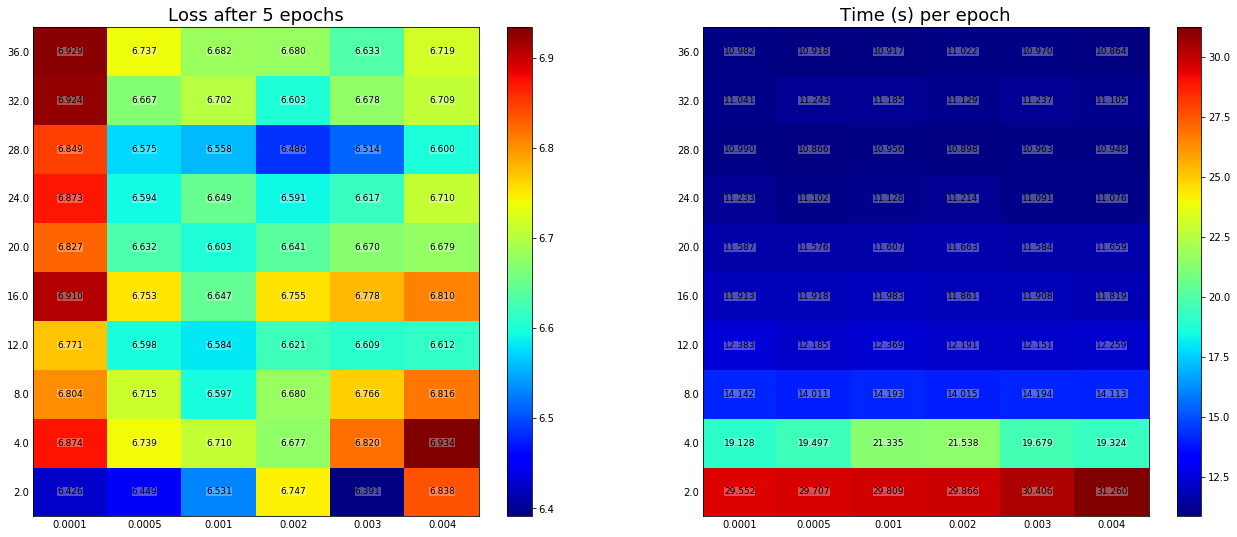

In [86]:
plt.rcParams['figure.figsize'] = 22,9
fig, ax = plt.subplots(1,2)
plotHeatMap(time_T,ax[1],"Time (s) per epoch","jet")
plotHeatMap(loss_T,ax[0],"Loss after 5 epochs","jet")

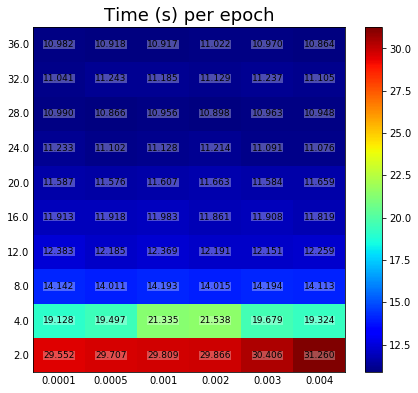

In [90]:
plt.rcParams['figure.figsize'] = 7,6.35
fig, ax = plt.subplots()
plotHeatMap(time_T,ax,"Time (s) per epoch","jet")

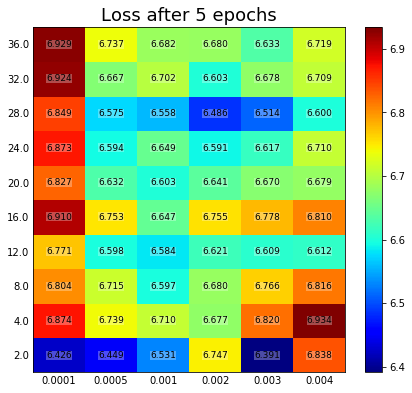

In [91]:
plt.rcParams['figure.figsize'] = 7,6.35
fig, ax = plt.subplots()
plotHeatMap(loss_T,ax,"Loss after 5 epochs","jet")